# g:Profiler Conversion

Lorem ipsum...

Note: our list of GO terms will not match the g:Profiler terms exactly, but should be consistent. This is expected! <-- Flesh this out

In [2]:
import re
from pathlib import Path

import networkx as nx
import pandas as pd
import seaborn as sns
from Bio import SeqIO
from loguru import logger
from tqdm import tqdm

from philharmonic.utils import (
    load_cluster_json,
    parse_GO_database,
    plot_cluster,
    print_cluster,
)

In [3]:
# Initial Files
cluster_file_path = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/20240917-pdamAll-phil_v0.3.0_clusters.functional.json"
network_file_path = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/20240917-pdamAll-phil_v0.3.0_network.positive.tsv"
go_map_path = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/20240917-pdamAll-phil_v0.3.0_GO_map.csv"

GO_DB = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/go.obo"

---

## Load Files

In [4]:
cluster_dict = load_cluster_json(cluster_file_path)
go_database = parse_GO_database(GO_DB)
full_G = nx.read_weighted_edgelist(network_file_path, delimiter="\t")

---

## Map to g:Profiler LOC IDs

- Download reference Ensembl genome
    ```bash
    $ wget  http://ftp.ensemblgenomes.org/pub/metazoa/release-59/fasta/pocillopora_damicornis_gca003704095v1/pep/Pocillopora_damicornis_gca003704095v1.ASM370409v1.pep.all.fa
    ```

- Create BLAST database
    ```bash
    $ makeblastdb -dbtype prot -title pdam_loc_db Pocillopora_damicornis_gca003704095v1.ASM370409v1.pep.all.fa
    ```

- Search against BLAST db
    ```bash
    $ ...
    ```

In [5]:
pdam_ensembl_fasta = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240930-gProfiler/Pocillopora_damicornis_gca003704095v1.ASM370409v1.pep.all.fa"
pdam_blast_results = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240930-gProfiler/pdam_loc_blast_results.tsv"

In [6]:
blast_results = (
    pd.read_csv(pdam_blast_results, sep="\t", header=None)
    .sort_values(0)
    .drop_duplicates([0, 1])
    .set_index(0)
)
blast_results = blast_results[blast_results[10] < 1e-5]
logger.info(f"{len(blast_results)} hits with e-value < 1e-5")
logger.info(f"{len(blast_results[1].unique())} unique hits")

2024-10-01 11:31:29.426 | INFO     | __main__:<module>:8 - 21894 hits with e-value < 1e-5
2024-10-01 11:31:29.431 | INFO     | __main__:<module>:9 - 17436 unique hits


In [7]:
blast_results.head()

,1,2,3,4,5,6,7,8,9,10,11
0,,,,,,,,,,,
pdam_00000001-RA,XP_027056588.1,100.000,360,0,0,1,360,31,390,0.000000e+00,737.0
pdam_00000002-RA,XP_027056458.1,93.440,747,14,2,1,712,13,759,0.000000e+00,1417.0
pdam_00000003-RA,XP_027056664.1,100.000,333,0,0,1,333,1,333,0.000000e+00,701.0
pdam_00000005-RA,XP_027056460.1,71.429,63,18,0,1,63,170,232,2.550000e-27,102.0
pdam_00000006-RA,XP_027056665.1,88.066,243,29,0,1,243,1,243,2.120000e-159,446.0


In [8]:
pep_fasta = SeqIO.to_dict(SeqIO.parse(pdam_ensembl_fasta, "fasta"))

REGEXP = ".*gene:(LOC\\d+) .*"
regcomp = re.compile(REGEXP)

xp_loc_map = {}
for k, v in pep_fasta.items():
    try:
        locid = regcomp.search(v.description).group(1)
        xp_loc_map[k] = locid
    except AttributeError:
        logger.warning(f"No match for {v.name}")

2024-09-30 14:37:02.680 | WARNING  | __main__:<module>:12 - No match for YP_001456710.1
2024-09-30 14:37:02.686 | WARNING  | __main__:<module>:12 - No match for YP_001456705.1
2024-09-30 14:37:02.688 | WARNING  | __main__:<module>:12 - No match for YP_001456711.1
2024-09-30 14:37:02.691 | WARNING  | __main__:<module>:12 - No match for YP_001456716.1
2024-09-30 14:37:02.693 | WARNING  | __main__:<module>:12 - No match for YP_001456704.1
2024-09-30 14:37:02.695 | WARNING  | __main__:<module>:12 - No match for YP_001456712.1
2024-09-30 14:37:02.695 | WARNING  | __main__:<module>:12 - No match for YP_001456714.1
2024-09-30 14:37:02.696 | WARNING  | __main__:<module>:12 - No match for YP_001456703.1
2024-09-30 14:37:02.697 | WARNING  | __main__:<module>:12 - No match for YP_001456708.1
2024-09-30 14:37:02.700 | WARNING  | __main__:<module>:12 - No match for YP_001456707.1
2024-09-30 14:37:02.701 | WARNING  | __main__:<module>:12 - No match for YP_001456706.1
2024-09-30 14:37:02.707 | WARNIN

---

## View g:Profiler Enrichment for a cluster

In [9]:
from gprofiler import GProfiler

gp = GProfiler(
    user_agent="ExampleTool",  # optional user agent
    return_dataframe=True,  # return pandas dataframe or plain python structures
)
PDAM_ORGANISM = "pdgca003704095v1"

In [10]:
def cluster_name_map(c, blast_map, loc_map):
    mapped_names = []
    for pdam_id in c["members"]:
        try:
            mapped_names.append(loc_map[blast_map.loc[pdam_id, 1]])
        except (KeyError, IndexError):
            logger.warning(f"{pdam_id} had no match in blast results")
    return mapped_names

In [11]:
logger.disable("__main__")
for k, cl in tqdm(cluster_dict.items(), total=len(cluster_dict)):
    cl["members_loc"] = cluster_name_map(cl, blast_results, xp_loc_map)
    cl["gprofiler"] = gp.profile(
        organism=PDAM_ORGANISM, query=cl["members_loc"], sources=["GO:BP"]
    )
logger.enable("__main__")
logger.info(f"Added gprofile annotations to {len(cluster_dict)} clusters")

logger.info(
    f"Writing results to {Path(cluster_file_path).with_suffix('.gprofile.pkl')}"
)
with open(Path(cluster_file_path).with_suffix(".gprofile.pkl"), "wb") as f:
    import pickle

    pickle.dump(cluster_dict, f)

100%|██████████| 610/610 [04:17<00:00,  2.37it/s]
2024-09-30 14:41:25.972 | INFO     | __main__:<module>:8 - Added gprofile annotations to 610 clusters
2024-09-30 14:41:25.972 | INFO     | __main__:<module>:10 - Writing results to /home/ssledzieski/philharmonic_results/p_damicornis/20240917-pdamAll-phil_v0.3.0/20240917-pdamAll-phil_v0.3.0_clusters.functional.gprofile.pkl


In [12]:
# i = 150
# k = list(clusters.keys())[i]
k = "549662403768153899"

In [19]:
print_cluster(cluster_dict[k], go_database, n_terms=10)

Cluster of 21 proteins [pdam_00022258-RA, pdam_00005419-RA, pdam_00017455-RA, ...] (hash 549662403768153899)
7 proteins re-added by ReCIPE (degree, 0.75)
Edges: 0
Triangles: 0
Max Degree: 0
Top Terms:
		GO:0071380 - <cellular response to prostaglandin E stimulus> (14)
		GO:0022900 - <electron transport chain> (14)
		GO:0019233 - <sensory perception of pain> (14)
		GO:0008542 - <visual learning> (13)
		GO:0010759 - <positive regulation of macrophage chemotaxis> (13)
		GO:0043278 - <response to morphine> (13)
		GO:0043547 - <positive regulation of GTPase activity> (13)
		GO:0010579 - <adenylate cyclase-activating G protein-coupled receptor signaling pathway> (13)
		GO:0007596 - <blood coagulation> (13)
		GO:0042493 - <response to xenobiotic stimulus> (13)



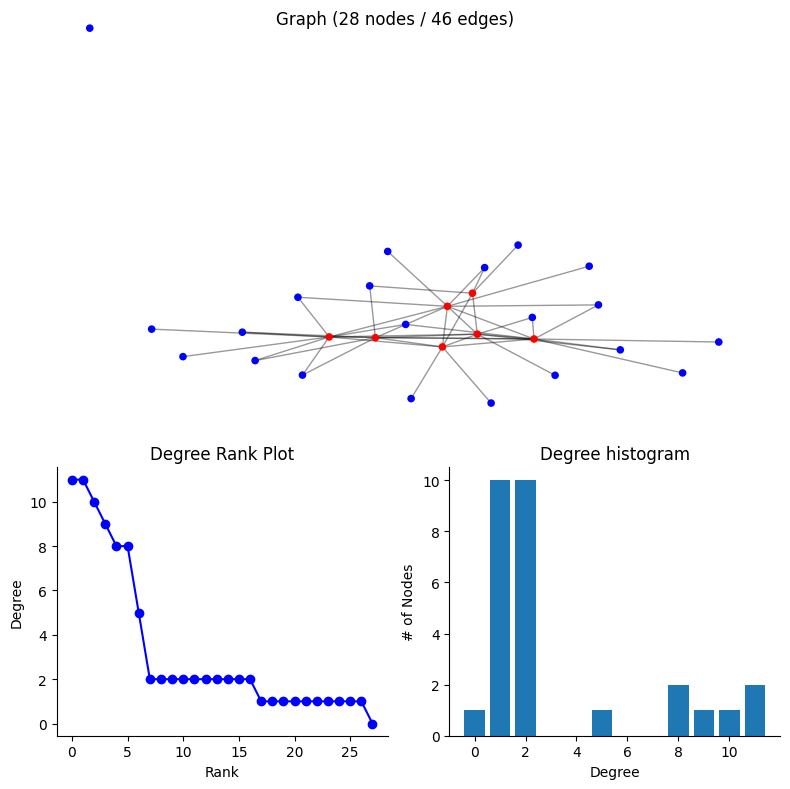

In [14]:
plot_cluster(cluster_dict[k], full_G)

In [15]:
cluster_dict[k]["gprofiler"]

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
0,GO:BP,GO:0007186,G protein-coupled receptor signaling pathway,0.000038,True,"""The series of molecular signals initiated by ...",1702,16,13,8782,0.8125,0.007638,query_1,[GO:0007165]
1,GO:BP,GO:0007165,signal transduction,0.000250,True,"""The cellular process in which a signal is con...",2442,16,14,8782,0.8750,0.005733,query_1,"[GO:0007154, GO:0009987, GO:0023052, GO:005079..."
2,GO:BP,GO:0023052,signaling,0.000278,True,"""The entirety of a process in which informatio...",2461,16,14,8782,0.8750,0.005689,query_1,[GO:0050789]
3,GO:BP,GO:0007154,cell communication,0.000300,True,"""Any process that mediates interactions betwee...",2475,16,14,8782,0.8750,0.005657,query_1,[GO:0009987]
4,GO:BP,GO:0051716,cellular response to stimulus,0.000956,True,"""Any process that results in a change in state...",2701,16,14,8782,0.8750,0.005183,query_1,"[GO:0009987, GO:0050896]"
5,GO:BP,GO:0050896,response to stimulus,0.001406,True,"""Any process that results in a change in state...",2781,16,14,8782,0.8750,0.005034,query_1,[GO:0008150]
6,GO:BP,GO:0050794,regulation of cellular process,0.012037,True,"""Any process that modulates the frequency, rat...",3277,16,14,8782,0.8750,0.004272,query_1,"[GO:0009987, GO:0050789]"
7,GO:BP,GO:0050789,regulation of biological process,0.017826,True,"""Any process that modulates the frequency, rat...",3378,16,14,8782,0.8750,0.004144,query_1,"[GO:0008150, GO:0065007]"
8,GO:BP,GO:0065007,biological regulation,0.021465,True,"""Any process that modulates a measurable attri...",3427,16,14,8782,0.8750,0.004085,query_1,[GO:0008150]
